# Zastosowanie drzew decyzyjnych oraz lasów losowych przy, gdzie y reprezentowany jest przez dane typu ciągłego**


## 1. Biblioteki

In [1]:
import pandas as pd
import sklearn.tree
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score #funkcje do badania dopasowania modelu
import dtreeviz.trees as dtv # importowanie dtreeviz

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

## 2. Wczytuje  i sprawdzam typ danych

In [2]:
train_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_train.csv')
test_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_test.csv')
val_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_val.csv')

train_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']
test_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']
val_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']

caly_df = pd.concat([train_df, test_df, val_df])
caly_df['Województwo']=caly_df['Województwo'].astype('category')
caly_df['Data urodzenia']=caly_df['Data urodzenia'].astype('category')

del caly_df["id"]
del caly_df["PF"]
del caly_df["Dokł. IE"]
del caly_df['kategoria']

In [3]:
caly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1881 entries, 0 to 188
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Województwo     1881 non-null   category
 1   Data urodzenia  1881 non-null   category
 2   IE              1881 non-null   int64   
 3   PI-PROD         1881 non-null   int64   
 4   PI-POKR         1881 non-null   int64   
 5   Prc             1881 non-null   int64   
 6   Psm             1881 non-null   int64   
 7   Pnr             1881 non-null   int64   
 8   Pw              1881 non-null   int64   
 9   PI-PLOD         1881 non-null   int64   
 10  CRj             1881 non-null   int64   
 11  CRk             1881 non-null   int64   
 12  PP              1881 non-null   int64   
 13  OMC             1881 non-null   int64   
 14  WH-KSOM         1881 non-null   int64   
 15  WH-DLUG         1881 non-null   int64   
 16  IP              1881 non-null   int64   
 17  kg ml          

### 3. Usuwam mniejszości zmiennych kategorycznych 

In [4]:
caly_df['Województwo'].value_counts()

WIELKOPOLSKIE          579
KUJAWSKO-POMORSKIE     298
OPOLSKIE               227
ZACHODNIOPOMORSKIE     212
PODLASKIE              175
MAZOWIECKIE            106
POMORSKIE               94
LUBUSKIE                47
ŁÓDZKIE                 41
DOLNOŚLĄSKIE            32
WARMIŃSKO-MAZURSKIE     23
ŚLĄSKIE                 17
ŚWIĘTOKRZYSKIE          13
MAŁOPOLSKIE             12
LUBELSKIE                4
PODKARPACKIE             1
Name: Województwo, dtype: int64

In [5]:
caly_df=caly_df[caly_df['Województwo']!='PODKARPACKIE']
caly_df=caly_df[caly_df['Województwo']!='LUBELSKIE']

In [6]:
caly_df['Województwo'].value_counts()

WIELKOPOLSKIE          579
KUJAWSKO-POMORSKIE     298
OPOLSKIE               227
ZACHODNIOPOMORSKIE     212
PODLASKIE              175
MAZOWIECKIE            106
POMORSKIE               94
LUBUSKIE                47
ŁÓDZKIE                 41
DOLNOŚLĄSKIE            32
WARMIŃSKO-MAZURSKIE     23
ŚLĄSKIE                 17
ŚWIĘTOKRZYSKIE          13
MAŁOPOLSKIE             12
LUBELSKIE                0
PODKARPACKIE             0
Name: Województwo, dtype: int64

In [7]:
caly_df['Data urodzenia'].value_counts()

2020    1066
2019     396
2018     275
2017      68
2021      47
2016      23
2015       1
Name: Data urodzenia, dtype: int64

In [8]:
caly_df=caly_df[caly_df['Data urodzenia']!=2015]

In [9]:
caly_df['Data urodzenia'].value_counts()

2020    1066
2019     396
2018     275
2017      68
2021      47
2016      23
2015       0
Name: Data urodzenia, dtype: int64

In [10]:
caly_label=caly_df["IE"]
del caly_df["IE"]

### 4. Zakodowuje zmienne kategoryczne 

In [11]:
a=pd.get_dummies(caly_df['Województwo'])
b=pd.get_dummies(caly_df['Data urodzenia'])
caly_df= pd.concat([caly_df,a,b], axis=1)
del caly_df['Województwo']
del caly_df['Data urodzenia']

In [12]:
caly_df

,PI-PROD,PI-POKR,Prc,Psm,Pnr,Pw,PI-PLOD,CRj,CRk,PP,...,ŁÓDZKIE,ŚLĄSKIE,ŚWIĘTOKRZYSKIE,2015,2016,2017,2018,2019,2020,2021
0,137,127,121,113,106,128,109,107,110,101,...,0,0,0,0,0,0,0,0,1,0
1,126,123,109,113,103,128,114,114,113,94,...,0,0,0,0,0,0,1,0,0,0
2,126,120,110,107,102,124,113,112,117,94,...,0,0,0,0,0,0,0,0,1,0
3,133,111,104,110,99,114,114,113,126,89,...,0,0,0,0,0,0,0,0,1,0
4,125,115,91,95,101,124,134,129,133,102,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,134,119,112,115,106,118,102,103,108,92,...,0,0,0,0,0,0,0,0,1,0
185,132,117,103,103,107,119,93,94,102,96,...,0,0,0,0,0,0,1,0,0,0
186,120,109,106,97,96,115,120,114,134,100,...,0,0,0,0,0,0,0,1,0,0
187,113,114,97,94,103,120,114,104,115,132,...,1,0,0,0,0,0,1,0,0,0


In [13]:
caly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 188
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PI-PROD              1875 non-null   int64  
 1   PI-POKR              1875 non-null   int64  
 2   Prc                  1875 non-null   int64  
 3   Psm                  1875 non-null   int64  
 4   Pnr                  1875 non-null   int64  
 5   Pw                   1875 non-null   int64  
 6   PI-PLOD              1875 non-null   int64  
 7   CRj                  1875 non-null   int64  
 8   CRk                  1875 non-null   int64  
 9   PP                   1875 non-null   int64  
 10  OMC                  1875 non-null   int64  
 11  WH-KSOM              1875 non-null   int64  
 12  WH-DLUG              1875 non-null   int64  
 13  IP                   1875 non-null   int64  
 14  kg ml                1875 non-null   int64  
 15  kg tł                1875 non-null   in

### 5. Tworzę metrykę do oceny dobierania parametrów


In [14]:
mae_scorer = make_scorer(mean_absolute_error)

## 6 Modele

Model liniowy nie wymaga standaryzacji

In [15]:
caly_df_zapas=caly_df

In [16]:
caly_df = np.array(caly_df)
caly_label = np.array(caly_label)

## 6.1 Model liniowy

## 6.1.1 Model liniowy - dobieram zmienne

In [17]:
estimator=LinearRegression()
selector = RFECV(estimator, step=1, cv=2,scoring=mae_scorer)
selector2 = selector.fit(caly_df, caly_label)                   

In [18]:
kombinacje=[]
nazwy_kolumn=caly_df_zapas.columns
dictionary = dict(zip(nazwy_kolumn, selector2.ranking_))
dictionary= dict(sorted(dictionary.items(), key=lambda item: item[1]))

In [19]:
dictionary

{2020: 1,
 2019: 2,
 'MAŁOPOLSKIE': 3,
 'ŚLĄSKIE': 4,
 'KUJAWSKO-POMORSKIE': 5,
 'ZACHODNIOPOMORSKIE': 6,
 'WIELKOPOLSKIE': 7,
 'MAZOWIECKIE': 8,
 'WH-KSOM': 9,
 'WH-DLUG': 10,
 'kg bi': 11,
 'IP': 12,
 'kg tł': 13,
 'WARMIŃSKO-MAZURSKIE': 14,
 'OMC': 15,
 'POMORSKIE': 16,
 'LUBUSKIE': 17,
 'ŁÓDZKIE': 18,
 'rc': 19,
 2018: 20,
 'PI-PLOD': 21,
 'sm': 22,
 2021: 23,
 'og': 24,
 'w': 25,
 'OPOLSKIE': 26,
 'PI-POKR': 27,
 'CRk': 28,
 'CRj': 29,
 'PP': 30,
 'DOLNOŚLĄSKIE': 31,
 2017: 32,
 'nr': 33,
 'PODLASKIE': 34,
 'PI-PROD': 35,
 'Pnr': 36,
 'ŚWIĘTOKRZYSKIE': 37,
 'Prc': 38,
 'Pw': 39,
 'Psm': 40,
 'kg ml': 41,
 2016: 42,
 '% tł': 43,
 '% bi': 44,
 'PODKARPACKIE': 45,
 'LUBELSKIE': 46,
 2015: 47}

In [20]:
nazwy_kolumn_2=[]
for x in dictionary.keys():
    nazwy_kolumn_2.append(x)

In [21]:

    
dane_do_porownania=pd.DataFrame(columns=["Liczba zmiennych",
                                    "Błąd"]
                                )
glowne_wyniki=[]
glowne_zmienne=[]
for i in range(0,len(nazwy_kolumn_2)):
    zmienne=[]
    for q in range(0,i+1):
        zmienne.append(nazwy_kolumn_2[q])
    kombinacje.append(zmienne)
    data_frame=caly_df_zapas[zmienne]
    kfold = KFold(n_splits=5, shuffle=False)

    data_frame = np.array(data_frame)
    caly_label = np.array(caly_label)
    
    wyniki=[]
    
    for train, test in kfold.split(data_frame, caly_label):
        reg = LinearRegression()
        reg.fit(data_frame[train], caly_label[train])
        predykcje=reg.predict(data_frame[test])
        
        dane_folda=pd.DataFrame({"pred": predykcje.ravel(),
                                    "obs": caly_label[test]
                                })
        
        dane_folda['blad']=abs(dane_folda['obs']-dane_folda['pred'])
        mae=dane_folda['blad'].sum()/len(dane_folda['blad'])
        wyniki.append(mae)
        
    wynik=sum(wyniki)/len(wyniki)
    glowne_wyniki.append(wynik)
    glowne_zmienne.append(i)
    
dane_do_porownania["Liczba zmiennych"]=glowne_zmienne
dane_do_porownania["Błąd"]=glowne_wyniki

index=list(dane_do_porownania["Błąd"]).index(min(list(dane_do_porownania["Błąd"])))

print(index,"\n",kombinacje[index])

40 
 [2020, 2019, 'MAŁOPOLSKIE', 'ŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'ZACHODNIOPOMORSKIE', 'WIELKOPOLSKIE', 'MAZOWIECKIE', 'WH-KSOM', 'WH-DLUG', 'kg bi', 'IP', 'kg tł', 'WARMIŃSKO-MAZURSKIE', 'OMC', 'POMORSKIE', 'LUBUSKIE', 'ŁÓDZKIE', 'rc', 2018, 'PI-PLOD', 'sm', 2021, 'og', 'w', 'OPOLSKIE', 'PI-POKR', 'CRk', 'CRj', 'PP', 'DOLNOŚLĄSKIE', 2017, 'nr', 'PODLASKIE', 'PI-PROD', 'Pnr', 'ŚWIĘTOKRZYSKIE', 'Prc', 'Pw', 'Psm', 'kg ml']


In [22]:
len(kombinacje[index])

41

In [23]:
dane_do_porownania.to_csv('Wyniki REFCV Regresja liniowa IE.csv',index=False)

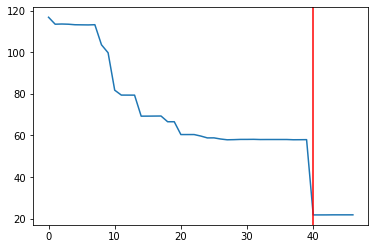

In [96]:
plt.plot(list(dane_do_porownania["Błąd"]))
plt.axvline(x=list(dane_do_porownania["Błąd"]).index(min(list(dane_do_porownania["Błąd"]))), color='r', linestyle='-')
plt.show()

In [97]:
dane_do_porownania["Błąd"]

0     116.794823
1     113.448780
2     113.542190
3     113.444612
4     113.189582
5     113.147074
6     113.104626
7     113.206670
8     103.562306
9      99.721112
10     81.744101
11     79.386553
12     79.378092
13     79.363273
14     69.258735
15     69.274557
16     69.301171
17     69.330583
18     66.574981
19     66.574789
20     60.421241
21     60.421129
22     60.422859
23     59.709095
24     58.813385
25     58.829321
26     58.284712
27     57.904602
28     57.973463
29     58.084830
30     58.091372
31     58.121987
32     58.027542
33     58.042964
34     58.041927
35     58.042451
36     58.042451
37     57.923922
38     57.943441
39     57.973816
40     21.802507
41     21.803059
42     21.811556
43     21.842134
44     21.841498
45     21.841336
46     21.842001
Name: Błąd, dtype: float64

In [98]:
kombinacje[41]

[2020,
 2019,
 'MAŁOPOLSKIE',
 'ŚLĄSKIE',
 'KUJAWSKO-POMORSKIE',
 'ZACHODNIOPOMORSKIE',
 'WIELKOPOLSKIE',
 'MAZOWIECKIE',
 'WH-KSOM',
 'WH-DLUG',
 'kg bi',
 'IP',
 'kg tł',
 'WARMIŃSKO-MAZURSKIE',
 'OMC',
 'POMORSKIE',
 'LUBUSKIE',
 'ŁÓDZKIE',
 'rc',
 2018,
 'PI-PLOD',
 'sm',
 2021,
 'og',
 'w',
 'OPOLSKIE',
 'PI-POKR',
 'CRk',
 'CRj',
 'PP',
 'DOLNOŚLĄSKIE',
 2017,
 'nr',
 'PODLASKIE',
 'PI-PROD',
 'Pnr',
 'ŚWIĘTOKRZYSKIE',
 'Prc',
 'Pw',
 'Psm',
 'kg ml',
 2016]

In [99]:
zestaw_caly=caly_df_zapas
zestaw_41=caly_df_zapas[kombinacje[41]]

zestaw_caly = np.array(zestaw_caly)
zestaw_41 = np.array(zestaw_41)

caly_label = np.array(caly_label)

In [100]:
caly_label

array([2120, 1912, 2126, ..., 2085, 1970, 2146], dtype=int64)

In [101]:
zestaw_caly

array([[137., 127., 121., ...,   0.,   1.,   0.],
       [126., 123., 109., ...,   0.,   0.,   0.],
       [126., 120., 110., ...,   0.,   1.,   0.],
       ...,
       [120., 109., 106., ...,   1.,   0.,   0.],
       [113., 114.,  97., ...,   0.,   0.,   0.],
       [126., 117., 107., ...,   0.,   1.,   0.]])

In [102]:
zestaw_41

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 1.130e+02, 1.370e+03,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.130e+02, 1.209e+03,
        0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.070e+02, 9.820e+02,
        0.000e+00],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 9.700e+01, 6.450e+02,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.400e+01, 6.080e+02,
        0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+02, 8.110e+02,
        0.000e+00]])

## 7 Cross validacja k=5

### 7.1 Wszystkie

In [107]:
kfold = KFold(n_splits=5, shuffle=False)
dane_do_zapisu_1=pd.DataFrame()
licznik=1
wart_1=[]
        
for train, test in kfold.split(zestaw_caly, caly_label):
    LR_1 = LinearRegression()
    LR_1.fit(zestaw_caly[train], caly_label[train])
    
    predykcje=LR_1.predict(zestaw_caly[test])
    dane_folda_1=pd.DataFrame({"pred": predykcje.ravel(),
                                "obs": caly_label[test],
                                "Fold":licznik})
    dane_do_zapisu_1=pd.concat([dane_do_zapisu_1,dane_folda_1])
    sredni_blad=mean_absolute_error(caly_label[test],predykcje)
    wart_1.append(sredni_blad)
    licznik+=1

In [108]:
wart_1

[21.859703080832464,
 22.463323918410847,
 21.882131937498887,
 20.245524430816342,
 22.761100632741893]

In [109]:
sum(wart_1)/len(wart_1)

21.842356800060088

### 8.4.2 zestaw 41

In [110]:
kfold = KFold(n_splits=5, shuffle=False)
dane_do_zapisu_2=pd.DataFrame()
licznik=1
wart_2=[]

for train, test in kfold.split(zestaw_41, caly_label):
    LR_2 = LinearRegression()
    
    LR_2.fit(zestaw_41[train], caly_label[train])
    predykcje=LR_2.predict(zestaw_41[test])
    dane_folda_2=pd.DataFrame({"pred": predykcje.ravel(),
                                "obs": caly_label[test],
                                "Fold":licznik})
    dane_do_zapisu_2=pd.concat([dane_do_zapisu_2,dane_folda_2])
    sredni_blad=mean_absolute_error(caly_label[test],predykcje)
    wart_2.append(sredni_blad)
    licznik+=1

In [111]:
wart_2

[21.85905305989583,
 22.407781412760418,
 21.775887939453124,
 20.238522216796873,
 22.734048950195312]

In [112]:
sum(wart_2)/len(wart_2)

21.803058715820313

### 8.5 Zapisuje predykcje Zestaw 22

In [54]:
dane_do_zapisu_2.to_csv("D:/STUDIA/ROK_II/Projekt/Predykcje_i błędy/Zestaw 2000/IE_GradientBoostingRegresor_FS.csv")